
# Four Panel Map

By reading model output data from a netCDF file, we can create a four panel plot showing:

* 300 hPa heights and winds
* 500 hPa heights and absolute vorticity
* Surface temperatures
* Precipitable water


In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr

from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo

In [3]:
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

In [4]:
# Function used to create the map subplots
def plot_background(ax):
    ax.set_extent([235., 290., 20., 55.])
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

In [5]:
# Open the example netCDF data
ds = xr.open_dataset(get_test_data('gfs_output.nc', False))
print(ds)

<xarray.Dataset> Size: 3MB
Dimensions:       (lat: 201, lon: 361, time: 1)
Coordinates:
  * lat           (lat) float32 804B 65.0 64.75 64.5 64.25 ... 15.5 15.25 15.0
  * lon           (lon) float32 1kB 220.0 220.2 220.5 ... 309.5 309.8 310.0
  * time          (time) datetime64[ns] 8B 2017-02-28T21:00:00
Data variables:
    temp          (time, lat, lon) float64 580kB ...
    precip_water  (time, lat, lon) float64 580kB ...
    heights_300   (time, lat, lon) float64 580kB ...
    heights_500   (time, lat, lon) float64 580kB ...
    vort_500      (time, lat, lon) float64 580kB ...
    winds_300     (time, lat, lon) float64 580kB ...
Attributes:
    title:     Test GFS Output Data
    subtitle:  For MetPy examples and tests


In [6]:
# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(ds['lon'], ds['lat'])

In [7]:
# Pull out the data
vort_500 = ds['vort_500'][0]
surface_temp = ds['temp'][0]
precip_water = ds['precip_water'][0]
winds_300 = ds['winds_300'][0]

In [8]:
# Do unit conversions to what we wish to plot
vort_500 = vort_500 * 1e5
surface_temp = surface_temp.metpy.convert_units('degF')
precip_water = precip_water.metpy.convert_units('inches')
winds_300 = winds_300.metpy.convert_units('knots')

In [9]:
# Smooth the height data
heights_300 = ndimage.gaussian_filter(ds['heights_300'][0], sigma=1.5, order=0)
heights_500 = ndimage.gaussian_filter(ds['heights_500'][0], sigma=1.5, order=0)

c:\Users\ravic\anaconda3\envs\geo_env\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\ravic\anaconda3\envs\geo_env\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
c:\Users\ravic\anaconda3\envs\geo_env\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


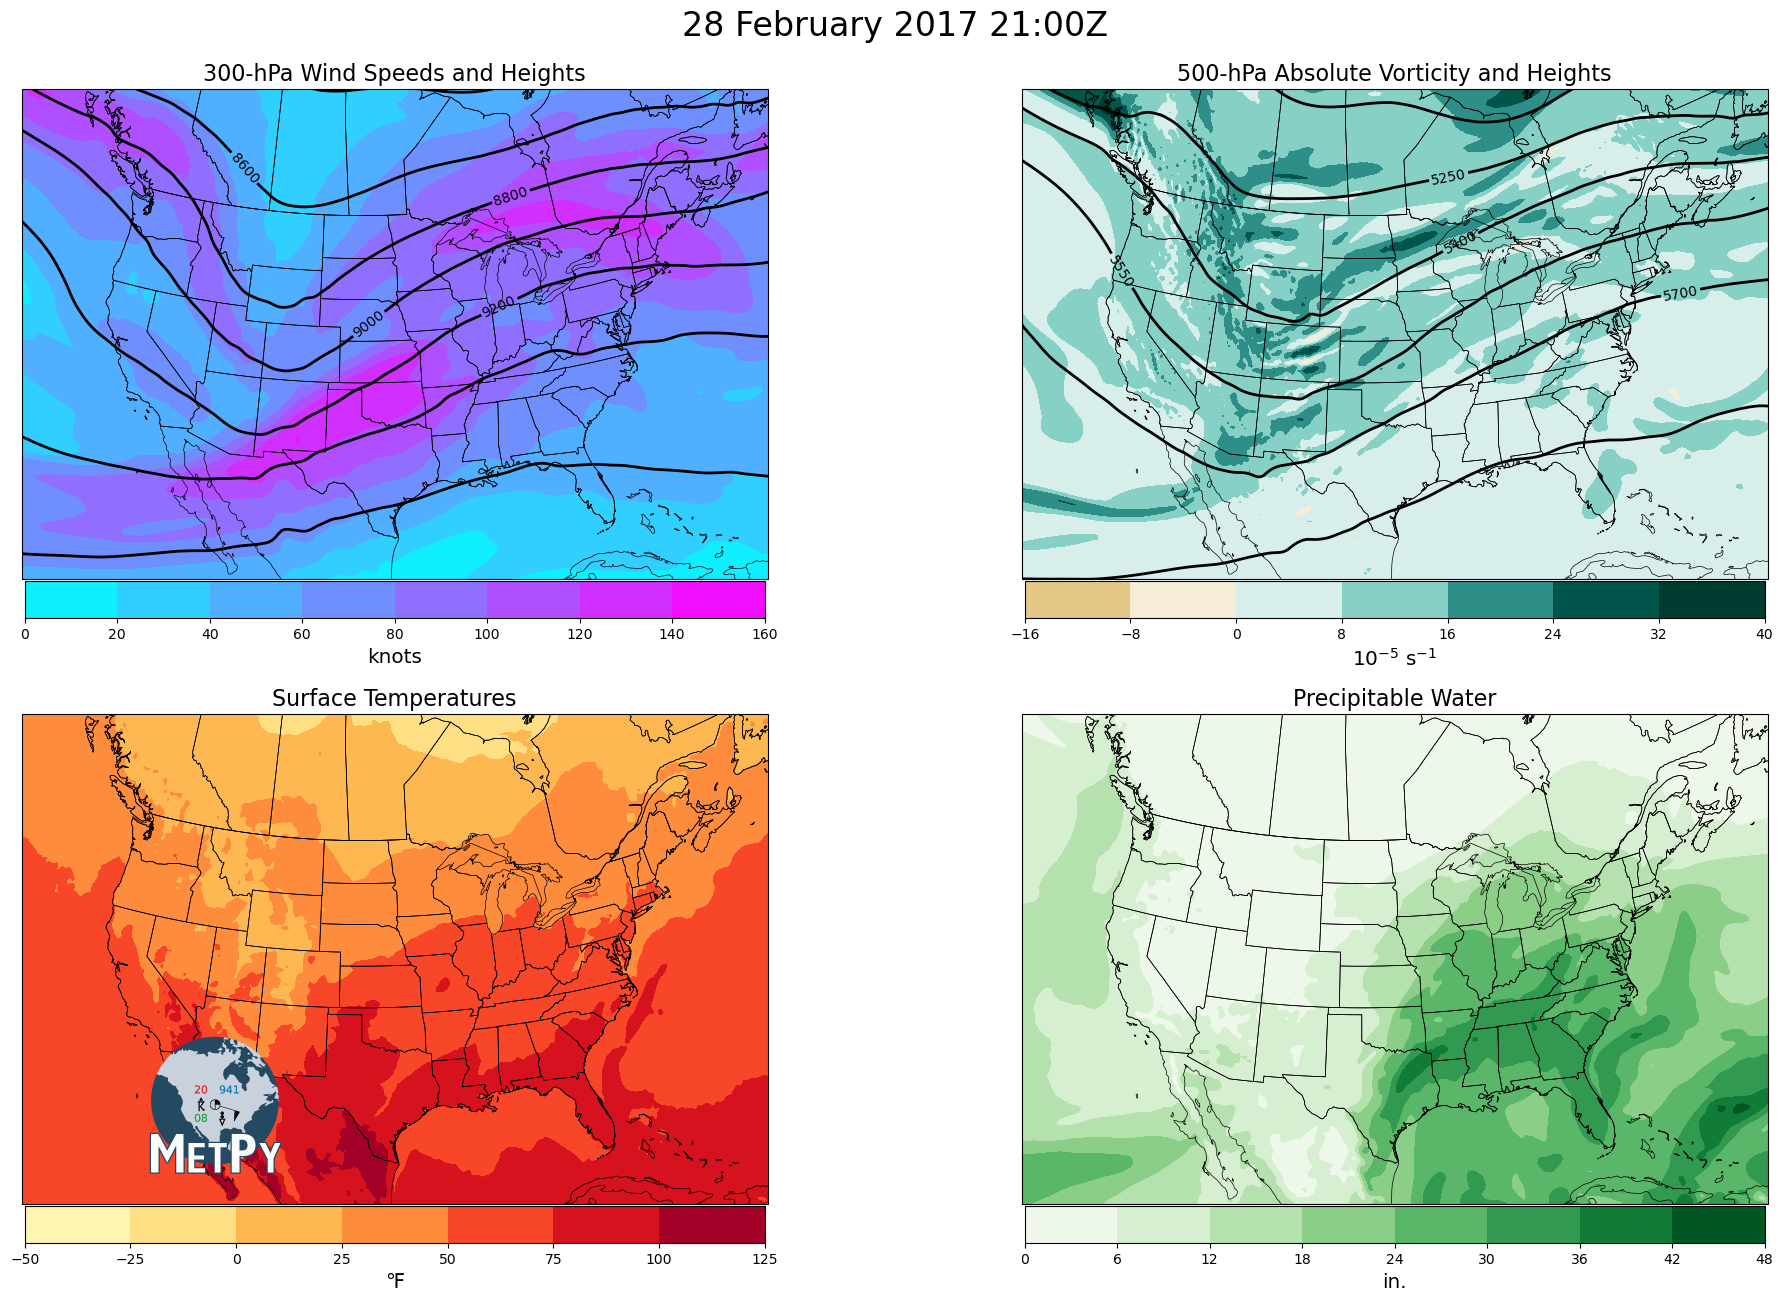

In [10]:
# Create the figure and plot background on different axes
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(20, 13), constrained_layout=True,
                          subplot_kw={'projection': crs})
add_metpy_logo(fig, 140, 120, size='large')
axlist = axarr.flatten()
for ax in axlist:
    plot_background(ax)

# Upper left plot - 300-hPa winds and geopotential heights
cf1 = axlist[0].contourf(lon_2d, lat_2d, winds_300, cmap='cool', transform=ccrs.PlateCarree())
c1 = axlist[0].contour(lon_2d, lat_2d, heights_300, colors='black', linewidths=2,
                       transform=ccrs.PlateCarree())
axlist[0].clabel(c1, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
axlist[0].set_title('300-hPa Wind Speeds and Heights', fontsize=16)
cb1 = fig.colorbar(cf1, ax=axlist[0], orientation='horizontal', shrink=0.74, pad=0)
cb1.set_label('knots', size='x-large')

# Upper right plot - 500mb absolute vorticity and geopotential heights
cf2 = axlist[1].contourf(lon_2d, lat_2d, vort_500, cmap='BrBG', transform=ccrs.PlateCarree(),
                         zorder=0, norm=plt.Normalize(-32, 32))
c2 = axlist[1].contour(lon_2d, lat_2d, heights_500, colors='k', linewidths=2,
                       transform=ccrs.PlateCarree())
axlist[1].clabel(c2, fontsize=10, inline=1, inline_spacing=1, fmt='%i', rightside_up=True)
axlist[1].set_title('500-hPa Absolute Vorticity and Heights', fontsize=16)
cb2 = fig.colorbar(cf2, ax=axlist[1], orientation='horizontal', shrink=0.74, pad=0)
cb2.set_label(r'$10^{-5}$ s$^{-1}$', size='x-large')

# Lower left plot - surface temperatures
cf3 = axlist[2].contourf(lon_2d, lat_2d, surface_temp, cmap='YlOrRd',
                         transform=ccrs.PlateCarree(), zorder=0)
axlist[2].set_title('Surface Temperatures', fontsize=16)
cb3 = fig.colorbar(cf3, ax=axlist[2], orientation='horizontal', shrink=0.74, pad=0)
cb3.set_label('\N{DEGREE FAHRENHEIT}', size='x-large')

# Lower right plot - precipitable water entire atmosphere
cf4 = axlist[3].contourf(lon_2d, lat_2d, precip_water, cmap='Greens',
                         transform=ccrs.PlateCarree(), zorder=0)
axlist[3].set_title('Precipitable Water', fontsize=16)
cb4 = fig.colorbar(cf4, ax=axlist[3], orientation='horizontal', shrink=0.74, pad=0)
cb4.set_label('in.', size='x-large')

# Set height padding for plots
fig.set_constrained_layout_pads(w_pad=0., h_pad=0.1, hspace=0., wspace=0.)

# Set figure title
fig.suptitle(ds['time'][0].dt.strftime('%d %B %Y %H:%MZ').values, fontsize=24)

# Display the plot
plt.show()